In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from scipy.stats import beta,norm,zscore,entropy
import matplotlib.patches as patches
import matplotlib.colors as colors
import seaborn as sns
%matplotlib inline

# analysis of cost/value

Weather forecasts are considered to have “value” when they result in beneficial decision-making by users (Murphy 1993). Several studies have shown that the value of a forecast can be estimated using a simple 2x2 decision problem, where value is expressed in terms of the benefit/utility of taking preventative action relative to the losses endured when adverse weather events occur. In this notebook, we explore ways of measuring and visualizing the performance of weather forecasts by evaluating the relative costs of misclassification errors (“false alarms” and “missed events”). Estimating the value of forecasts for rare hazardous events is a significant challenge, given the catastrophic damages that can result from these events along with minuscule event frequencies (base rates).

## 2x2 contingency table

Forecasts for a well-defined observed event can be evaluated by analyzing the elements of a 2x2 contingency table. A generic form of the 2x2 contingency table is shown below. The observed value for the $i^{th}$ case can be denoted as $x_i = 1$ (or $obs=yes$) when the event was observed to occur,  $x_i = 0$ (or $obs=no$) when the event did not occur (following the notation of Murphy 1988). Forecasts could be provided in one of several forms: continuous (e.g., probabilistic), ordinal (e.g., slight/moderate/high), or binary (yes/no). Continuous and ordinal forecast values can be converted to binary forecasts via thresholding, $f_i = 1$ (or $fcst=yes$) when the forecast value is greater than or equal to a threshold,  $f_i = 0$ (or $fcst=no$) otherwise. The elements of the contingency table are simply the relative frequencies or proportions of each contingency (joint probabilities).

The “a” element of the contingency table provides the proportion of correct “yes” forecasts, often referred to as “true positives” or “hits”. The “b” element provides the proportion of incorrect “yes” forecasts, also known as “false positives” or “false alarms”. The “c” element provides the proportion of incorrect “no” forecasts, also denoted as “false negatives” or “missed events”. The “d” element provides the proportion of correct “no” forecasts, also called “true negatives” or “correct nulls”.

In [121]:
# generic 2x2 contingency table
pd.DataFrame(data=np.array([['a','b','a+b'],['c','d','c+d'],['a+c','b+d','1']]),index=['fcst=yes','fcst=no','col sum'],columns=['obs=yes','obs=no','row sum'])

,obs=yes,obs=no,row sum
fcst=yes,a,b,a+b
fcst=no,c,d,c+d
col sum,a+c,b+d,1


## 2x2 contingency table in ROC space

We can use the definitions of $POD=\frac{a}{a+c},POFD=\frac{b}{b+d},$ and $\bar x = a+c$ to express the elements of the 2x2 contingency table in terms of $POD$, $POFD$, and $\bar x$, this will come in handy later:

In [127]:
# generic 2x2 contingency table in terms of POD, POFD, and base rate
pd.DataFrame(data=np.array([[r'$\bar x (POD)$',r'$(1-\bar x)POFD$',r'$\bar x (POD)+(1-\bar x)POFD$'],[r'$\bar x (1-POD)$',r'$(1-\bar x)(1-POFD)$',r'$1-\bar x (POD)+(1-\bar x)POFD$'],[r'$\bar x$',r'$1-\bar x$','1']]),index=['fcst=yes','fcst=no','col sum'],columns=['obs=yes','obs=no','row sum'])

,obs=yes,obs=no,row sum
fcst=yes,$\bar x (POD)$,$(1-\bar x)POFD$,$\bar x (POD)+(1-\bar x)POFD$
fcst=no,$\bar x (1-POD)$,$(1-\bar x)(1-POFD)$,$1-\bar x (POD)+(1-\bar x)POFD$
col sum,$\bar x$,$1-\bar x$,1


## cost matrix - general score

For a specific decision-maker, we can consider the "costs" (reduction in benefit) or "utility" (additional benefit) of the binary decision of taking protective action (or not) in anticipation of a hazardous event. In this case, another 2x2 table is created which we will call the "cost matrix". The $C_a$ element is the cost incurred when protective action is taken and the event occurs, while the $C_b$ element is the cost incurred when protective action is taken and the event does not occur. (these could be equal to each other if the protective action is "perfect") The $C_d$ element is the cost incurred when no protective action is taken and the event does not occur (often assumed to be zero) while the $C_c$ element is the cost incurred when protective action is not taken and the event occurs, typically assumed to be the largest cost of the four contingencies.

In [123]:
# generic 2x2 cost matrix
pd.DataFrame(data=np.array([[r'$C_a$',r'$C_b$'],[r'$C_c$',r'$C_d$']]),index=['action','no action'],columns=['event','no event'])

,event,no event
action,$C_a$,$C_b$
no action,$C_c$,$C_d$


Thompson (1952) and Murphy (1977) assumed that “the cost of taking protective measures” was $C_a=C_b=C$ , the loss resulting from not taking protective action when hazardous weather occurred was $C_c=L$ , and no costs were incurred when the weather event did not occur and no protective action was taken ($C_d=0$). Richardson (2000) allowed for “preventable loss” ($C_a=C+L-L_1, C_b=C, C_c=L, C_d=0$) which is additional loss beyond the cost of taking protective action when the weather event also occurred. Wandishin and Brooks (2002) considered “utility” instead of cost, allowing for analysis of various reductions in utility occurring in the contingencies when the weather event was either predicted or observed to occur.

By taking the sum of the element-by-element product of the 2x2 contingency table with the cost matrix, we can derive a measure representing the overall “full cost” of using a forecast system for decision-making, lower cost is “better”. 

\begin{equation}
costfull = C_a a + C_b b + C_c c + C_d d
\end{equation}

## classic cost-loss ratio approach

Thompson (1952) and Murphy (1977) assumed that “the cost of taking protective measures” was $C_a=C_b=C$ , the loss resulting from not taking protective action when hazardous weather occurred was $C_c=L$ , and no costs were incurred when the weather event did not occur and no protective action was taken ($C_d=0$). Murphy (1977) defined “expense” as the expense per unit loss per forecast. 

The "cost-loss ratio" is simply the ratio of the cost of taking protection action to the loss resulting from not taking protective action when the event occurred:
\begin{equation}
cost/loss = \frac{C}{L}
\end{equation}

Plugging these into the equations above:

\begin{equation}
expense = \frac{costfull}{L} = (\frac{C}{L}-1)\bar x(POD)+\frac{C}{L}(1-\bar x)POFD + \bar x
\end{equation}

Analysis of $expense$ for a given forecast system ($POD,POFD$) and base rate across the full range of decision-makers is typically performed by plotting $expense(\frac{C}{L})$ vs $\frac{C}{L}$

## reference conditions

The expense/cost of a forecast system is typically compared to a couple of "reference" conditions; the costs associated with always taking protective action, costs associated with never taking protective action, and a perfect forecast. Using the Murphy (1977) definition of expense:

### perfect

For a perfect forecast system, $POD=1$ and $POFD=0$, therefore:

$expense_{perfect} = \frac{C}{L}\bar x$


### always protect

For a user who always takes protective action, this is equivalent to a constant "yes" forecast, $POD=1$ and $POFD=1$, therefore:

$expense_{always} = \frac{C}{L}$


### never protect

For a user who never takes protective action, this is equivalent to a constant "no" forecast, $POD=0$ and $POFD=0$, therefore:

$expense_{never} = \bar x$


### reference expense

We assume the decision-maker is aware of their cost/loss situation as well as the base rate (event frequency), and will choose the least-costly "default" decision when no forecast information is available. This will depend on $\frac{C}{L}$ compared with $\bar x$

if $\frac{C}{L}\le\bar x$;
$expense_{ref} = \frac{C}{L}$

if $\frac{C}{L}\gt\bar x$;
$expense_{ref} = \bar x$

## example

We'll use a simple model of the discrimination ability of a forecast system, following Brooks (2004) and originating with classic work by Thurstone (1927). The conditional distributions of the forecast (given "yes" and "no" observations) follow a normal distribution with equal variances, with a separation between them measured in terms of the number of standard deviations between them (we will call this separation distance $d'$). In this example, $d'=1.2$

Text(0.5, 1.0, "standard normal separated by d'=1.2")

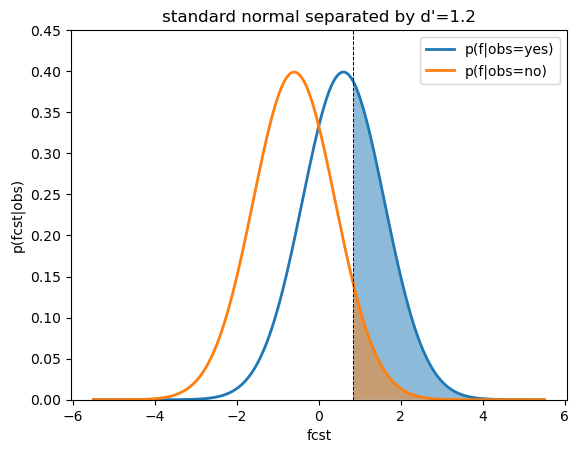

In [184]:
# plot a discrimination diagram for standard normal distribution conditional forecast distributions separated by dprime1
fig,ax = plt.subplots()
dprime1=1.2
x1=np.linspace(-5.5,5.5,1001)
p1=norm.pdf(x1,loc=0.5*dprime1,scale=1.)
p0=norm.pdf(x1,loc=-0.5*dprime1,scale=1.)
ax.plot(x1,p1,label='p(f|obs=yes)',lw=2.)
ax.plot(x1,p0,label='p(f|obs=no)',lw=2.)
ax.plot([x1[577],x1[577]],[0,0.45],'k--',lw=0.7)
ax.fill_between(x1[577:],p1[577:],alpha=0.5)
ax.fill_between(x1[577:],p0[577:],alpha=0.5)
ax.legend()
ax.set_xlabel('fcst')
ax.set_ylabel('p(fcst|obs)')
ax.set_ylim(0.,0.45)
ax.set_title(f"standard normal separated by d'={dprime1}")

## example ROC curve

We can choose a specific forecast decision threshold and compute the elements of the resulting 2x2 contingency table associated with that threshold. The area under the $p(f|obs=yes)$ curve to the right of the threshold is equal to $POD=\frac{a}{a+c}$ and area under the $p(f|obs=no)$ curve to the right of the threshold is equal to $POFD=\frac{b}{b+d}$. A ROC curve is produced by systematically varying this threshold and plotting $POD$ vs $POFD$. The example ROC curve for $d'=1.2$ follows ($POD=0.4$ and $POFD=0.07$ for the threshold shown above):

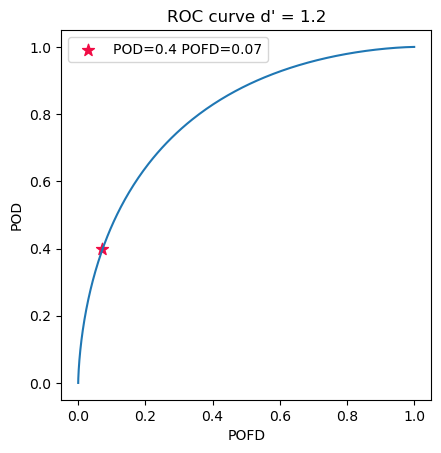

In [171]:
# example ROC curve

fig,ax = plt.subplots()
dprime1=1.2

pod1=norm.cdf(np.linspace(-5.5,5.5,1001),loc=-0.5*dprime1,scale=1.)
pofd1=norm.cdf(np.linspace(-5.5,5.5,1001),loc=0.5*dprime1,scale=1.)
pod_pt=np.round(pod1[np.argmax(pod1>0.4)],2)
pofd_pt=np.round(pofd1[np.argmax(pod1>0.4)],2)
lab1=f'POD={pod_pt} POFD={pofd_pt}'

ax.scatter(pofd_pt,pod_pt,marker='*',s=80,color='#f10c45',label=lab1)
ax.plot(pofd1,pod1)
ax.set_xlabel('POFD')
ax.set_ylabel('POD')
ax.set_title(f"ROC curve d' = {dprime1}")
ax.set_aspect('equal')
ax.legend()

## example Murphy expense curve

For this example $POD=0.4$, $POFD=0.07$, and assuming the base rate is $\bar x=0.1$, the Murphy (1977) expense curve is a plot of $expense$ vs $\frac{C}{L}, example found below:

$expense = (\frac{C}{L}-1)\bar x(POD)+\frac{C}{L}(1-\bar x)POFD + \bar x$

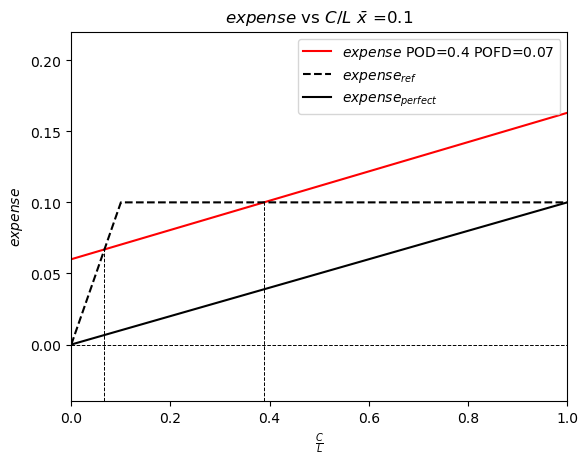

In [202]:
#example Murphy expense curve

xbar1=0.1
pod1=0.4
pofd1=0.07

# calculate locations of curve intersections
aa1=pod1*xbar1
bb1=(1.-xbar1)*pofd1
cc1=(1.-pod1)*xbar1
dd1=(1.-xbar1)*(1.-pofd1)
cl_low=cc1/(cc1+dd1)
cl_hi=aa1/(aa1+bb1)
exp_low=xbar1*(1.-pod1)+cl_low*(xbar1*pod1+(1.-xbar1)*pofd1)
exp_hi=xbar1*(1.-pod1)+cl_hi*(xbar1*pod1+(1.-xbar1)*pofd1)

cost_loss=np.linspace(0.0,1.,101)
expense=np.zeros_like(cost_loss)
expense_clim=np.zeros_like(cost_loss)
expense_perf=np.zeros_like(cost_loss)

expense=xbar1*(1.-pod1)+cost_loss*(xbar1*pod1+(1.-xbar1)*pofd1)
expense_clim[cost_loss<xbar1]=cost_loss[cost_loss<xbar1]
expense_clim[cost_loss>=xbar1]=xbar1
expense_perf=cost_loss*xbar1

plt.plot(cost_loss,expense,color='xkcd:fire engine red',label=r'$expense$'+f' POD={np.round(pod1,2)} POFD={np.round(pofd1,2)}')
plt.plot(cost_loss,expense_clim,'k--',label=r'$expense_{ref}$')
plt.plot(cost_loss,expense_perf,'k',label=r'$expense_{perfect}$')

plt.plot([0.,1.],[0.,0.],'k--',lw=0.7)
plt.plot([cl_low,cl_low],[-0.04,exp_low],'k--',lw=0.7)
plt.plot([cl_hi,cl_hi],[-0.04,exp_hi],'k--',lw=0.7)
plt.xlim(0.,1.0)
plt.ylim(-0.04,.22)

plt.title(r'$expense$ vs $C/L$ $\bar x$ ='+f'{xbar1}')
plt.xlabel(r'$\frac{C}{L}$')
plt.ylabel(r'$expense$')
plt.legend()


## points where expense curve intersects the reference curve

In this example we see that the forecast system will result in $expense$ less than the "default" reference forecast for users in the range of $\frac{C}{L}$ between roughly 0.07 and 0.38. Wandinshin and Brooks (2002) showed that the lower bound of $\frac{C}{L}$ where the forecast is less costly (intersection point of $expense$ and $expense_{ref}$ curves) is equal to the "miss ratio" ($MR=\frac{c}{c+d}$) and the upper bound is equal to the "success ratio" ($SR=\frac{a}{a+b}$). 

These intersection points can also be derived by substituting the definitions of $a$ and $b$ from the 2x2 contingency table in ROC space:

$a=\bar x(POD)$

$b=(1-\bar x)POFD$

$\bar x = a+c$

$expense = (\frac{C}{L}-1)a+\frac{C}{L}b + a + c$

upper bound: $expense = expense_{ref} = \bar x$ at $\frac{C}{L}=\frac{a}{a+b}$

lower bound: $expense = expense_{ref} = \frac{C}{L}$ at $\frac{C}{L}=\frac{c}{c+d}$

## who benefits (or does not benefit) from using forecasts

This shows the range of decision-makers that can benefit from using this forecast system. We find that users with $\frac{C}{L}$ near the base rate tend to benefit from using the forecast, and the greatest benefit (largest difference between $expense$ and $expense_{ref}$) is found for users at $\frac{C}{L}=\bar x$. Decision-makers with a very high loss or very low cost of protection (low $\frac{C}{L}$) require highly accurate forecasts in order for their decisions to result in less expenses in comparison to their "default" decision, which is "always protect". For these users, the relatively high losses associated with the hazard makes them more sensitive to "missed event" errors. On the other side of the chart, decision-makers with a relatively high cost of protection (high $\frac{C}{L}$) or low event frequency also require highly accurate forecasts in order for those to be considered beneficial in comparision with their "never protect" default decision. For these users, the relatively high cost of taking protective action makes them more sensitive to "false alarm" errors.

## relative value

While these Murphy (1977) expense curves are fairly easy to produce and interpret, to this point they have not been adopted widely across the community. Instead, a skill score based on $expense$ called "relative value" has been used, which was also presented by Murphy (1977). Relative value is defined as the value of the forecast relative to the value of a perfect forecast, where "value" is the difference between $expense$ and the default reference $expense_{ref}$.

relative value = $V_{rel}$

\begin{equation}
V_{rel}=\frac{expense_{ref}-expense}{expense_{ref}-expense_{perfect}}
\end{equation}

/tmp/ipykernel_3653272/2356968270.py:24: RuntimeWarning: divide by zero encountered in divide
  rel_value=(expense_clim-expense)/(expense_clim-expense_perf)


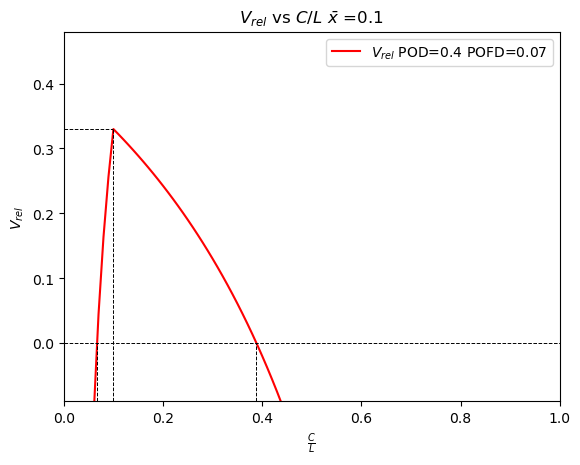

In [208]:
#example relative value curve

xbar1=0.1
pod1=0.4
pofd1=0.07

# calculate locations of zero crossings
aa1=pod1*xbar1
bb1=(1.-xbar1)*pofd1
cc1=(1.-pod1)*xbar1
dd1=(1.-xbar1)*(1.-pofd1)
cl_low=cc1/(cc1+dd1)
cl_hi=aa1/(aa1+bb1)

cost_loss=np.linspace(0.0,1.,101)
expense=np.zeros_like(cost_loss)
expense_clim=np.zeros_like(cost_loss)
expense_perf=np.zeros_like(cost_loss)

expense=xbar1*(1.-pod1)+cost_loss*(xbar1*pod1+(1.-xbar1)*pofd1)
expense_clim[cost_loss<xbar1]=cost_loss[cost_loss<xbar1]
expense_clim[cost_loss>=xbar1]=xbar1
expense_perf=cost_loss*xbar1
rel_value=(expense_clim-expense)/(expense_clim-expense_perf)

plt.plot(cost_loss,rel_value,color='xkcd:fire engine red',label=r'$V_{rel}$'+f' POD={np.round(pod1,2)} POFD={np.round(pofd1,2)}')

plt.plot([0.,1.],[0.,0.],'k--',lw=0.7)
plt.plot([0.,xbar1],[pod1-pofd1,pod1-pofd1],'k--',lw=0.7)
plt.plot([xbar1,xbar1],[-0.09,pod1-pofd1],'k--',lw=0.7)
plt.plot([cl_low,cl_low],[-0.09,0.],'k--',lw=0.7)
plt.plot([cl_hi,cl_hi],[-0.09,0.],'k--',lw=0.7)
plt.xlim(0.,1.0)
plt.ylim(-0.09,.48)

plt.title(r'$V_{rel}$ vs $C/L$ $\bar x$ ='+f'{xbar1}')
plt.xlabel(r'$\frac{C}{L}$')
plt.ylabel(r'$V_{rel}$')
plt.legend()


## features of the relative value curve

The relative value curve provides similar information as the expense curve, except it is positively oriented (higher score is "better"). $V_{rel}=1$ for a perfect forecast, and we find the same range of decision-makers that can benefit from using the forecast as before (lower bound of $\frac{C}{L}$ is equal to the "miss ratio" ($MR=\frac{c}{c+d}$) and the upper bound is equal to the "success ratio" ($SR=\frac{a}{a+b}$). In addition, the peak relative value is found at $\frac{C}{L}=\bar x$ and Richardson (2000) showed that $V_{rel}=POD-POFD$ (Peirce skill score) at that point. Users with $\frac{C}{L}\lt MR$ and $\frac{C}{L}\gt SR$ will not benefit from the forecast and have negative $V_{rel}$. In fact, since the denominator of $V_{rel}$ approaches zero as $\frac{C}{L}$ approaches both zero and one, $V_{rel}$ approaches negative infinity at the low/high $\frac{C}{L}$ ends of the diagram. Since highly negative $V_{rel}$ scores are common, typically only $V_{rel}\ge0$ scores are plotted, but in this example some of the negative values are displayed to illustrate the behavior of this score.

Text(0, 0.5, 'POD POFD')

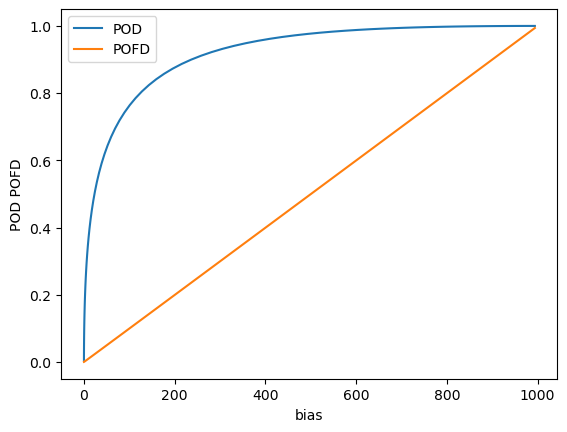

In [28]:
xbar=0.001
dprime1=2.

pod1=norm.cdf(np.linspace(-3.5,3.5,101),loc=-0.5*dprime1,scale=1.)
pofd1=norm.cdf(np.linspace(-3.5,3.5,101),loc=0.5*dprime1,scale=1.)
fbar=xbar*pod1+(1.-xbar)*pofd1
bias=fbar/xbar
plt.plot(bias,pod1,label='POD')
plt.plot(bias,pofd1,label='POFD')
plt.legend()
plt.xlabel('bias')
plt.ylabel('POD POFD')

(0.0, 1.0)

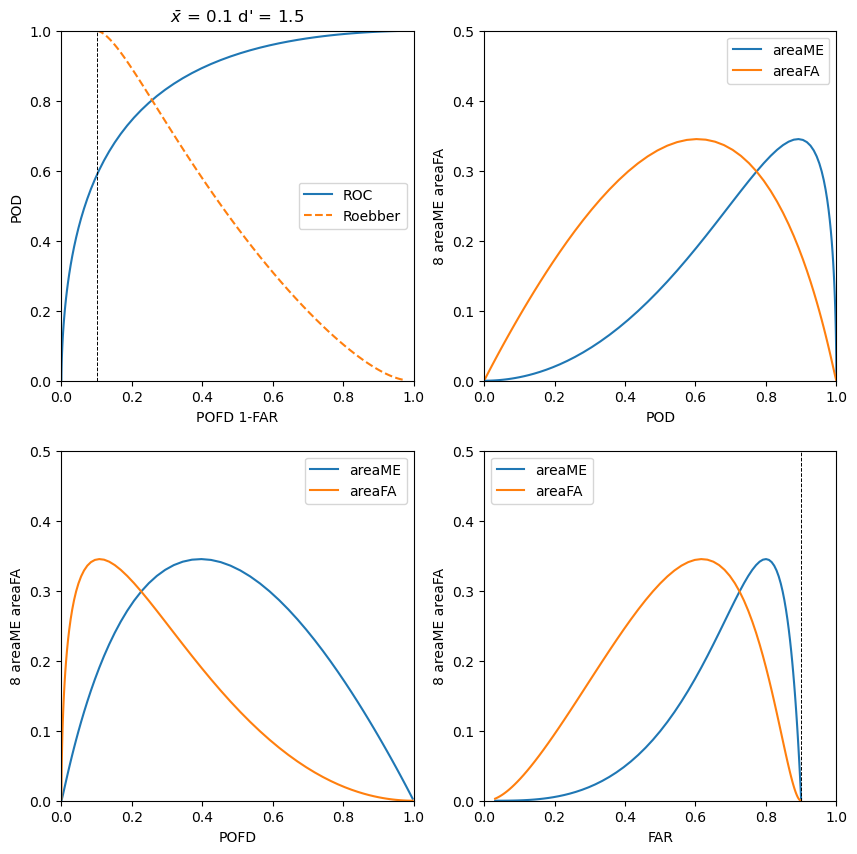

In [72]:
xbar=0.1
dprime1=1.5

pod1=norm.cdf(np.linspace(-3.5,3.5,101),loc=-0.5*dprime1,scale=1.)
pofd1=norm.cdf(np.linspace(-3.5,3.5,101),loc=0.5*dprime1,scale=1.)
fbar=xbar*pod1+(1.-xbar)*pofd1
bias=fbar/xbar
xodd=xbar/(1.-xbar)
far1=pofd1/bias/xodd
areame=(pod1-pofd1)*(pod1-pofd1)/(2.-pod1-pofd1)
areafa=(pod1-pofd1)*(pod1-pofd1)/(pod1+pofd1)
fig, ax = plt.subplots(2,2,figsize=(10,10))
axs=ax.flat
axs[3].plot(far1,areame,label='areaME')
axs[3].plot(far1,areafa,label='areaFA')
axs[3].plot([1.-xbar,1.-xbar],[0,1],'k--',lw=0.7)

axs[3].legend()
axs[3].set_xlabel('FAR')
axs[3].set_ylabel('8 areaME areaFA')
axs[3].set_xlim(0.,1.)
axs[3].set_ylim(0.,0.5)
axs[1].plot(pod1,areame,label='areaME')
axs[1].plot(pod1,areafa,label='areaFA')
axs[1].legend()
axs[1].set_xlabel('POD')
axs[1].set_ylabel('8 areaME areaFA')
axs[1].set_xlim(0.,1.)
axs[1].set_ylim(0.,0.5)

axs[2].plot(pofd1,areame,label='areaME')
axs[2].plot(pofd1,areafa,label='areaFA')
axs[2].legend()
axs[2].set_xlabel('POFD')
axs[2].set_ylabel('8 areaME areaFA')
axs[2].set_xlim(0.,1.)
axs[2].set_ylim(0.,0.5)

axs[0].plot(pofd1,pod1,label='ROC')
axs[0].plot((1.-far1),pod1,label='Roebber',ls='--')
axs[0].plot([xbar,xbar],[0,1],'k--',lw=0.7)
axs[0].legend()
axs[0].set_xlabel('POFD 1-FAR')
axs[0].set_ylabel('POD')
axs[0].set_title(r'$\bar x$'+f' = {xbar}'+" d' = "+f'{dprime1}')
axs[0].set_xlim(0.,1.)
axs[0].set_ylim(0.,1.)

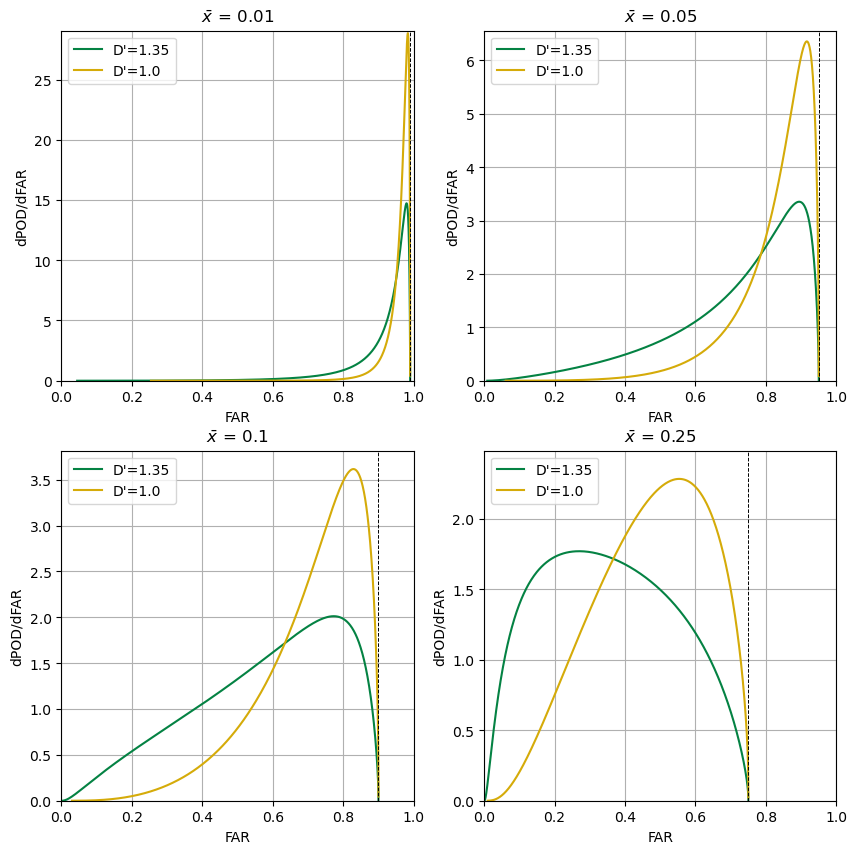

In [120]:

dprime1=1.35
dprime2=1.
xbars=np.array([0.01,0.05,0.1,0.25])
fig, ax = plt.subplots(2,2,figsize=(10,10))
axs=ax.flat

for i in np.arange(4):
    xbar=xbars[i]
    pod1=norm.cdf(np.linspace(-5.5,5.5,1001),loc=-0.5*dprime1,scale=1.)
    pofd1=norm.cdf(np.linspace(-5.5,5.5,1001),loc=0.5*dprime1,scale=1.)
    fbar1=xbar*pod1+(1.-xbar)*pofd1
    bias1=fbar1/xbar
    xodd=xbar/(1.-xbar)
    far1=pofd1/bias1/xodd
    
    pod2=norm.cdf(np.linspace(-5.5,5.5,1001),loc=-0.5*dprime2,scale=1.)
    pofd2=norm.cdf(np.linspace(-5.5,5.5,1001),loc=0.5*dprime2,scale=1.)
    fbar2=xbar*pod2+(1.-xbar)*pofd2
    bias2=fbar2/xbar
    far2=pofd2/bias2/xodd
    axs[i].plot(far1,np.gradient(pod1,far1),label="D'=1.35",color='#048243')
    axs[i].plot(far2,np.gradient(pod2,far2),label="D'=1.0",color='#d5ab09')
    axs[i].legend()
    axs[i].set_xlabel('FAR')
    axs[i].set_ylabel('dPOD/dFAR')
    axs[i].set_title(r'$\bar x$ = '+f'{xbar}')
    axs[i].grid()
    pmax=np.max(np.gradient(pod2,far2))
    axs[i].plot([1.-xbar,1.-xbar],[0.,pmax+0.2],'k--',lw=0.7)
    axs[i].set_xlim(0.,1.)
    axs[i].set_ylim(0.,pmax+0.2)

(0.0, 1.0)

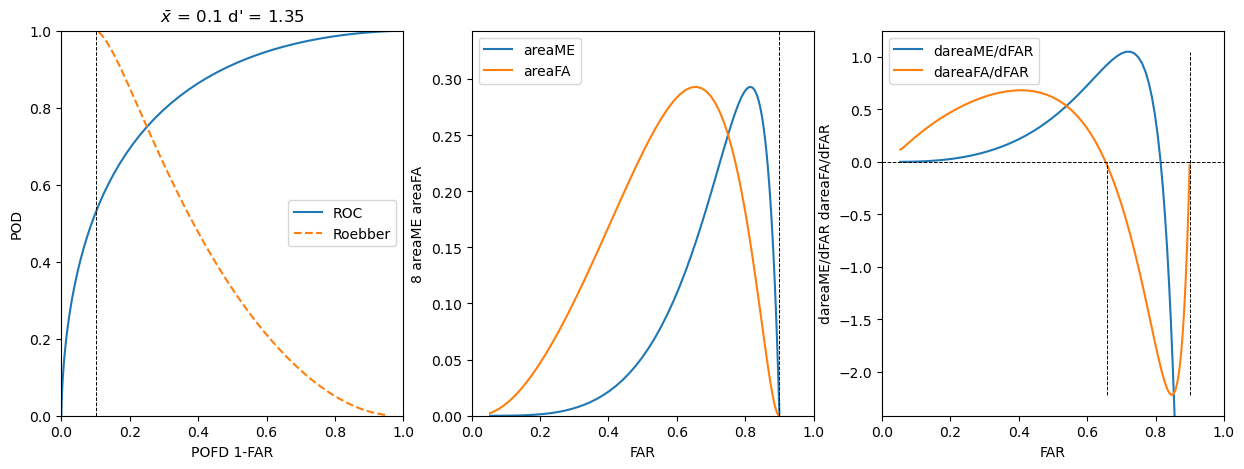

In [104]:
xbar=0.1
dprime1=1.35

pod1=norm.cdf(np.linspace(-3.5,3.5,101),loc=-0.5*dprime1,scale=1.)
pofd1=norm.cdf(np.linspace(-3.5,3.5,101),loc=0.5*dprime1,scale=1.)
fbar=xbar*pod1+(1.-xbar)*pofd1
bias=fbar/xbar
xodd=xbar/(1.-xbar)
far1=pofd1/bias/xodd
areame=(pod1-pofd1)*(pod1-pofd1)/(2.-pod1-pofd1)
areafa=(pod1-pofd1)*(pod1-pofd1)/(pod1+pofd1)
fzer=far1[np.argmax(np.gradient(areafa,far1)<0.)]
fig, ax = plt.subplots(1,3,figsize=(15,5))
axs=ax.flat
pmax=np.max([np.max(np.gradient(areafa,far1)),np.max(np.gradient(areame,far1))])
pmin=np.max([np.min(np.gradient(areafa,far1)),np.min(np.gradient(areame,far1))])
axs[2].plot(far1,np.gradient(areame,far1),label='dareaME/dFAR')
axs[2].plot(far1,np.gradient(areafa,far1),label='dareaFA/dFAR')
axs[2].plot([1.-xbar,1.-xbar],[pmin,pmax],'k--',lw=0.7)
axs[2].plot([fzer,fzer],[pmin,0.],'k--',lw=0.7)

axs[2].plot([0,1],[0,0],'k--',lw=0.7)
axs[2].legend()
axs[2].set_xlabel('FAR')
axs[2].set_ylabel('dareaME/dFAR dareaFA/dFAR')
axs[2].set_xlim(0.,1.)
axs[2].set_ylim(pmin-0.2,pmax+0.2)
pmax2=np.max([np.max(areafa),np.max(areame)])
axs[1].plot(far1,areame,label='areaME')
axs[1].plot(far1,areafa,label='areaFA')
axs[1].plot([1.-xbar,1.-xbar],[0,1],'k--',lw=0.7)
axs[1].legend()
axs[1].set_xlabel('FAR')
axs[1].set_ylabel('8 areaME areaFA')
axs[1].set_xlim(0.,1.)
axs[1].set_ylim(0.,pmax2+0.05)


axs[0].plot(pofd1,pod1,label='ROC')
axs[0].plot((1.-far1),pod1,label='Roebber',ls='--')
axs[0].plot([xbar,xbar],[0,1],'k--',lw=0.7)
axs[0].legend()
axs[0].set_xlabel('POFD 1-FAR')
axs[0].set_ylabel('POD')
axs[0].set_title(r'$\bar x$'+f' = {xbar}'+" d' = "+f'{dprime1}')
axs[0].set_xlim(0.,1.)
axs[0].set_ylim(0.,1.)

In [90]:
pmax

6.592415970247217

In [86]:
np.gradient(areafa,far1)<0.

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

Text(0, 0.5, 'POFD/POD')

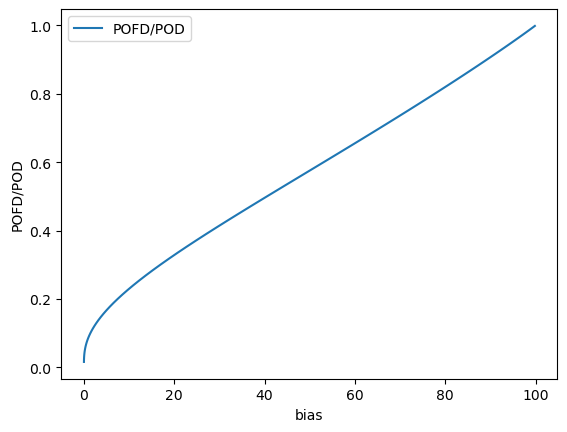

In [49]:
xbar=0.01
dprime1=1.1

pod1=norm.cdf(np.linspace(-3.5,3.5,101),loc=-0.5*dprime1,scale=1.)
pofd1=norm.cdf(np.linspace(-3.5,3.5,101),loc=0.5*dprime1,scale=1.)
fbar=xbar*pod1+(1.-xbar)*pofd1
bias=fbar/xbar
plt.plot(bias,pofd1/pod1,label='POFD/POD')
#plt.plot(bias,pofd1,label='POFD')
plt.legend()
plt.xlabel('bias')
plt.ylabel('POFD/POD')

Text(0, 0.5, 'POD FAR')

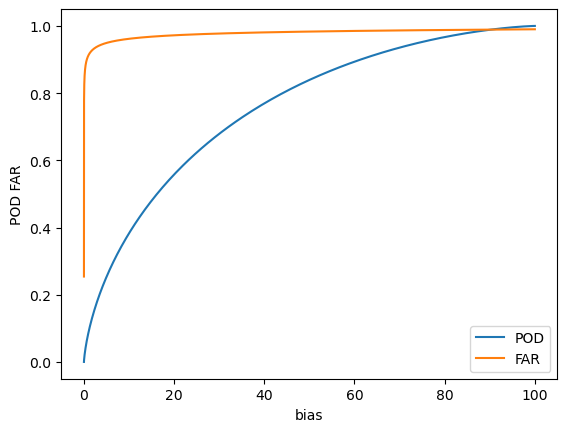

In [50]:
xbar=0.01
dprime1=1.

pod1=norm.cdf(np.linspace(-5.5,5.5,1001),loc=-0.5*dprime1,scale=1.)
pofd1=norm.cdf(np.linspace(-5.5,5.5,1001),loc=0.5*dprime1,scale=1.)
fbar=xbar*pod1+(1.-xbar)*pofd1
xodd=xbar/(1.-xbar)
far1=pofd1/(xodd*pod1+pofd1)
bias=fbar/xbar
plt.plot(bias,pod1,label='POD')
plt.plot(bias,far1,label='FAR')
plt.legend()
plt.xlabel('bias')
plt.ylabel('POD FAR')

In [ ]:
# calculate/plot the cost curve for a theoretical probabilistic system following a constant dprime curve
jj=0
pod1=1.
pofd1=1.
for zscore in zscores:
    a_xbar=norm.cdf(zscore,loc=-0.5*dprime1,scale=1.)
    b_1mxbar=norm.cdf(zscore,loc=0.5*dprime1,scale=1.)
    xbar1=0.1
    xodd=xbar1/(1.-xbar1)
    aa1=a_xbar*xbar1
    bb1=b_1mxbar*(1.-xbar1)
    cc1=xbar1-aa1
    dd1=(1.-xbar1)-bb1
    pod2=aa1/(aa1+cc1)
    pofd2=bb1/(bb1+dd1)
    alpha2=(pod1-pod2)/((pod1-pod2)+(pofd1-pofd2))
    alpha_prob[jj]=pod2*(1.-pod2)/(pod2*(1.-pod2)+pofd2*(1.-pofd2))
    cost_prob[jj]=pofd2*(1.-pod2)*(1.+pod2-pofd2)/(pod2*(1.-pod2)+pofd2*(1.-pofd2))
    print(pod2,pofd2,bb1/(aa1+bb1))
    pod1=pod2
    pofd1=pofd2
    jj=jj+1
plt.plot(alpha_prob,cost_prob,'m',lw=0.7,ls='--',label=f'dprime = {np.round(dprime1,1)}')
plt.plot(alpha,cost_always,'g--',label=r'$cost_{norm}$ always')
plt.plot(alpha,cost_never,'k--',label=r'$cost_{norm}$ never')
